# [프로젝트5] AutoEncoder 모델로 이상치 탐지하기

---

## 프로젝트 목표
---

AutoDencoder 모델을 사용하여 MME 장비의 이상치 탐지


## 프로젝트 목차
---

<div class="toc"><ul class="toc-item"><li><span><a href="#1.-데이터-읽기" data-toc-modified-id="1.-데이터-읽기-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>1. 데이터 읽기</a></span><ul class="toc-item"><li><span><a href="#라이브러리-불러오기" data-toc-modified-id="라이브러리-불러오기-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>라이브러리 불러오기</a></span></li><li><span><a href="#데이터-불러오기" data-toc-modified-id="데이터-불러오기-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>데이터 불러오기</a></span></li></ul></li><li><span><a href="#데이터-준비하기" data-toc-modified-id="데이터-준비하기-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>데이터 준비하기</a></span><ul class="toc-item"><li><span><a href="#Train,-Test-데이터-선택" data-toc-modified-id="Train,-Test-데이터-선택-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train, Test 데이터 선택</a></span></li><li><span><a href="#데이터-정규화" data-toc-modified-id="데이터-정규화-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>데이터 정규화</a></span></li><li><span><a href="#데이터-타임스탬프-설정" data-toc-modified-id="데이터-타임스탬프-설정-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>데이터 타임스탬프 설정</a></span></li></ul></li><li><span><a href="#AutoEncoder-모델-학습하기" data-toc-modified-id="AutoEncoder-모델-학습하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>AutoEncoder 모델 학습하기</a></span><ul class="toc-item"><li><span><a href="#모델-설정" data-toc-modified-id="모델-설정-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>모델 설정</a></span></li><li><span><a href="#학습-모듈-만들고-학습하기" data-toc-modified-id="학습-모듈-만들고-학습하기-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>학습 모듈 만들고 학습하기</a></span></li><li><span><a href="#학습-결과-확인하기" data-toc-modified-id="학습-결과-확인하기-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>학습 결과 확인하기</a></span></li></ul></li><li><span><a href="#AutoEncoder-모델-평가하기" data-toc-modified-id="AutoEncoder-모델-평가하기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>AutoEncoder 모델 평가하기</a></span><ul class="toc-item"><li><span><a href="#예측하기" data-toc-modified-id="예측하기-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>예측하기</a></span></li><li><span><a href="#임계값-넘는-이상치-탐지" data-toc-modified-id="임계값-넘는-이상치-탐지-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>임계값 넘는 이상치 탐지</a></span></li></ul></li></ul></div>

## 데이터 읽기

---

### 라이브러리 불러오기
---

본 프로젝트에 필요한 라이브러리를 불러옵니다.

In [1]:
import copy
import IPython
import warnings
import numpy as np
import pandas as pd
import pickle

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.preprocessing import StandardScaler

# *- torch -* 
import torch
import torch.nn as nn
from torch.utils.data import ( Dataset, DataLoader, random_split) 


%matplotlib inline
warnings.filterwarnings(action='ignore') # warning ignore 
pd.options.display.max_rows = 80
pd.options.display.max_columns = 80
sns.set_style("whitegrid")

SEED = 2022
np.random.seed(SEED)
torch.manual_seed(SEED)

### 데이터 불러오기
---

프로젝트 1에서 전처리가 끝난 데이터(`MME_data.p`) 를 불러옵니다. 또한 기기별로 이상치 탐지를 하기 위하여 기기 정보를 devices로 저장해 놓도록 합니다. 

In [2]:
# load 
with open('MME_data.p', 'rb') as fp:
    total_df = pickle.load(fp)

In [3]:
# 데이터를 쉽게 불러오기 위하여 기기를 정의
devices = [
    "MME017",
    "MME018",
    "MME071",
    "MME072",
    "MME073",
    "MME074",
    "MME091",
    "MME092",
    "MME093",
]

## 데이터 준비하기

### Train, Test 데이터 선택

AutoEncoder에 학습과 훈련데이터를 설정합니다.

한 기기에서 신호 하나를 골라서 앞시간의 신호와 뒷시간의 신호로 훈련과 학습 데이터를 분리합니다.

In [4]:
def dependency_plot(df):
    total_indices = list(range(len(df)))
    total_values = df.values
    plt.plot(total_indices, total_values, color="green")
    plt.show()

In [5]:
df_1 = total_df[devices[0]]["ue_dtch_att"]
train_size = int(len(df_1) * 0.7)

training = df_1.iloc[:train_size]
testing = df_1.iloc[train_size:]

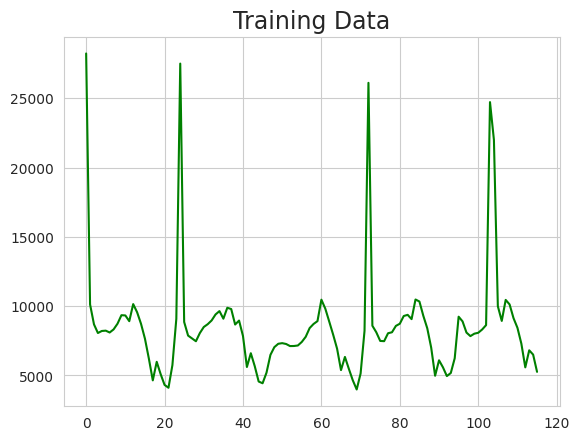

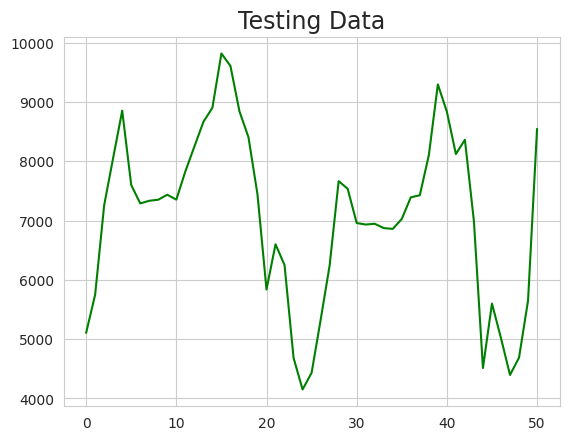

In [6]:
# 그래프 확인
plt.title("Training Data", fontsize=17)
dependency_plot(training)

plt.title("Testing Data", fontsize=17)
dependency_plot(testing)


### 데이터 정규화

ARIMA 모델처럼 정상성을 확인 할 필요는 없지만 데이터를 정규화 해주어야합니다.
이에 훈련과 평가데이터에 표준정규화를 각각 해주도록 합니다.

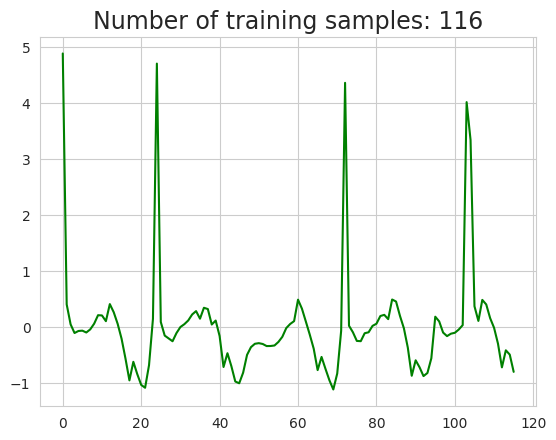

In [10]:
# 훈련데이터의 평균과 분산을 구합니다.
training_mean = training.mean()
training_std = training.std()
training_value = (training - training_mean) / training_std

# 그래프 확인
plt.title(f"Number of training samples: {len(training_value)}", fontsize=17)
dependency_plot(training_value)

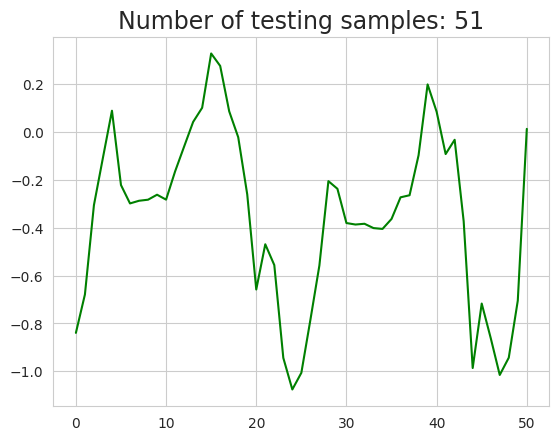

In [11]:
# 테스트 데이터 정규화
# 테스트 데이터를 정규화 할 때는 훈련 데이터에서 얻어낸 평균과 표준편차로 정규화합니다.
test_value = (testing - training_mean) / training_std

# 그래프 확인
plt.title(f"Number of testing samples: {len(test_value)}", fontsize=17)
dependency_plot(test_value)

### 데이터 타임스탬프 설정

시계열 데이터를 다루기 위해서 타임스탬프를 설정하고, 설정된 타임스탬프 마다 데이터가 누적 될 수 있도록 합니다.

In [12]:
def create_sequences(values, time_steps=12):
    """
        Summary: Timestamp를 12 로 설정해 rolling 해줍니다. 
    """
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])

    result = np.stack(output)
    return result.reshape(result.shape[0], result.shape[1], 1)



In [13]:
# Timestamp 설정
TIME_STEPS = 4

# train 데이터 변형 시키기 
X_train = create_sequences(training_value.reset_index()['ue_dtch_att'].values, TIME_STEPS)
print(f"| Training input shape | Batch:{X_train.shape[0]:>6d} | Timestamp:{X_train.shape[1]} |  ")

# test 데이터 변형 시키기 
X_test = create_sequences(test_value.values, TIME_STEPS)
print(f"| Testing input shape  | Batch:{X_test.shape[0]:>6d} | Timestamp:{X_test.shape[1]} |  ")

| Training input shape | Batch:   113 | Timestamp:4 |  
| Testing input shape  | Batch:    48 | Timestamp:4 |  


## AutoEncoder 모델 학습하기


### 모델 설정 

Autoencoder 모델은 인코더와 디코더로 이루어져있으며, 인코딩 된 표현을 학습한 다음 후 학습 된 인코딩 표현에서 입력 데이터를 가능한한 가깝게 생성하는 것을 목표로 합니다.

### [TODO] AutoEncoder 모델 설정하기

Autoencoder 모델은 인코더와 디코더로 이루어져있으며, 인코딩 된 표현을 학습한 다음 후 학습 된 인코딩 표현에서 입력 데이터를 가능한한 가깝게 생성하는 것을 목표로 합니다.

아래와 같은 모형을 갖도록 모델을 생성해 줍니다. 

```
Our Model:	
Conv1DAutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(32, 16, kernel_size=(7,), stride=(1,), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(1,), padding=(3,))
  )
)
```

In [14]:
class Conv1DAutoEncoder(nn.Module):
    """A 1D-Convolutional  Autoencoder"""
    def __init__(self,seq_len, kernel_size=7, embedding_dim=32, hidden_dim=16):
        super().__init__()
        assert( seq_len < embedding_dim), "embedding_dim must be lager than input sequence length"
        assert( hidden_dim < embedding_dim), "hidden_dim must be smaller than embedding_dim"

        # *- 인코더 -* #
        self.encoder = nn.Sequential(
            nn.Conv1d(1, embedding_dim, stride=1, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2, inplace=False),
            
            nn.Conv1d(embedding_dim, hidden_dim, stride=1, kernel_size=kernel_size, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2, inplace=False)
        )
        # *- 디코더 -* #
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim, stride=1, kernel_size=kernel_size, padding=3),
            nn.ReLU(),
            nn.Dropout(0.2, inplace=False),
            
            nn.ConvTranspose1d(hidden_dim, embedding_dim, stride=1, kernel_size=kernel_size, padding=3),
            nn.ReLU(),
            nn.ConvTranspose1d(embedding_dim, 1, stride=1, kernel_size=kernel_size, padding=3)
        )

    def forward(self, x):
        '''*- 전체 모델 -*'''
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Conv1DAutoEncoder(seq_len=X_train.shape[1], embedding_dim=32, hidden_dim=16)
model = model.to(device)

print('--- 사용 할 1D-Conv AutoEncoder 구조 ----\n')
print(model)

--- 사용 할 1D-Conv AutoEncoder 구조 ----

Conv1DAutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(32, 16, kernel_size=(7,), stride=(1,), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
    (4): ReLU()
    (5): ConvTranspose1d(32, 1, kernel_size=(7,), stride=(1,), padding=(3,))
  )
)


### 학습 모듈 만들고 학습하기 

In [16]:
class ConfigDict(dict):
    def __init__(self):
        self.__dict__ = self


class AutoencoderDataset(Dataset):
    '''Array --> Torch Dataset'''
    def __init__(self, x):
        self.x = x

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.x[idx, :, :])
        x = torch.transpose(x, 0, 1)
        return x
     

class Trainer:
    def __init__(self, model, cfg, device, train_dataset):
        self.cfg = cfg
        self.device = device
        self.train_dataset = train_dataset

        self.model, self.criterion, self.optimizer = self.compile_(model)
        self.train_dataloader, self.va_dataloader = self.create_trainloader(train_dataset)

        print('-'*86)
        print("\n".join(f"Argument: {k:<12s} ={v:>10}" for k, v in vars(self.cfg).items()))
        print("Argument: {:<12s} ={:>10}".format("DEVICE", device.__str__()))
        print('-'*86)
        print("\nOur Model:\t")
        print(self.model)
        print('-'*86)

    def create_trainloader(self, train_dataset):
        """make dataset and dataloader"""

        X_train_dataset = train_dataset

        total_len = len(X_train_dataset)
        valid_len = int(total_len* self.cfg.VALID_RATIO)

        train_dataset, valid_dataset = random_split(
            X_train_dataset, [total_len-valid_len, valid_len])
        train_dataloader = DataLoader(train_dataset,
                                        batch_size=self.cfg.BATCH_SIZE)
        va_dataloader = DataLoader(valid_dataset,
                                    batch_size=valid_len)

        return train_dataloader, va_dataloader


    def compile_(self, model):
        model = model.to(self.device)
        criterion = nn.__dict__[self.cfg.LOSS]().to(self.device)
        optimizer = torch.optim.__dict__[self.cfg.OPTIMIZER](model.parameters(), lr=self.cfg.LR)

        return model, criterion, optimizer

    def fit_(self):
        """train & valid """
        print('TRAINNIG START ...\n')
        history = dict(train=[], val=[])
        # best_model_wts = None
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = 10000.0

        for epoch in range(self.cfg.EPOCH):
            # training 
            self.model.train()
            train_losses = []
            for batch_idx, batch_x in enumerate(self.train_dataloader):
                self.optimizer.zero_grad()
                batch_x_tensor = batch_x.to(self.device)
                seq_pred = self.model(batch_x_tensor)
                loss = self.criterion(seq_pred, batch_x_tensor)
                loss.backward()
                self.optimizer.step()
                train_losses.append(loss.item())
            # validating 
            self.model.eval()
            val_losses = []
            with torch.no_grad():
                for batch_idx, va_x in enumerate(self.va_dataloader):
                    va_x_tensor = va_x.to(device)
                    seq_pred = self.model(va_x_tensor)
                    loss = self.criterion(seq_pred, va_x_tensor)
                    val_losses.append(loss.item())
            
            # stacking
            train_loss = np.mean(train_losses)
            val_loss = np.mean(val_losses)
            history['train'].append(train_loss)
            history['val'].append(val_loss)
        
            # save the best model 
            if val_loss < best_loss:
                best_loss = val_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            
            # print 
            if epoch % self.cfg.PRINT_FREQ ==0: 
                print(f'| Epoch {epoch:03d} | Train loss :{train_loss:.4f} | Val loss {val_loss:.4f} |')

        # Recover the best model
        model.load_state_dict(best_model_wts)
        return model, history

def plot_results(history, cfg):
    """summary for plot_results

    Args:
        history ([type]): [description]
        cfg ([type]): [description]
    """
    plt.title(f'Training&Validationg {cfg.LOSS}', fontsize=17)
    plt.plot(history["train"], label="Training Loss")
    plt.plot(history["val"], label="Validation Loss")
    plt.legend()
    plt.show()

In [17]:
#---------------------------
# ConfigDict
#---------------------------
# DON'T CHANGE THIS
config = ConfigDict()
config.EPOCH = 50 # TOTAL EPOCH 
config.LR = 1e-3 # Learning rate
config.BATCH_SIZE = 4 # bach size of dataset
config.VALID_RATIO = 0.1

# Changable variables 
config.OPTIMIZER = 'Adam' # or 'SGD'
config.LOSS = 'MSELoss' # or 'L1LOSS'
config.PRINT_FREQ = 5 # print period of log

In [18]:
# ------------------------
# Train the model
# ------------------------
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_dataset = AutoencoderDataset(X_train)

trainer = Trainer(model, config, device, train_dataset)

--------------------------------------------------------------------------------------
Argument: EPOCH        =        50
Argument: LR           =     0.001
Argument: BATCH_SIZE   =         4
Argument: VALID_RATIO  =       0.1
Argument: OPTIMIZER    =      Adam
Argument: LOSS         =   MSELoss
Argument: PRINT_FREQ   =         5
Argument: DEVICE       =       cpu
--------------------------------------------------------------------------------------

Our Model:	
Conv1DAutoEncoder(
  (encoder): Sequential(
    (0): Conv1d(1, 32, kernel_size=(7,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Conv1d(32, 16, kernel_size=(7,), stride=(1,), padding=same)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose1d(16, 16, kernel_size=(7,), stride=(1,), padding=(3,))
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): ConvTranspose1d(16, 32, kernel_size=(7,), stride=(1,), padding=(3,))
  

In [19]:
model, history = trainer.fit_()

TRAINNIG START ...

| Epoch 000 | Train loss :0.8126 | Val loss 0.8878 |
| Epoch 005 | Train loss :0.0932 | Val loss 0.0613 |
| Epoch 010 | Train loss :0.0935 | Val loss 0.0425 |
| Epoch 015 | Train loss :0.0821 | Val loss 0.0281 |
| Epoch 020 | Train loss :0.0884 | Val loss 0.0365 |
| Epoch 025 | Train loss :0.0741 | Val loss 0.0433 |
| Epoch 030 | Train loss :0.0808 | Val loss 0.0398 |
| Epoch 035 | Train loss :0.0753 | Val loss 0.0218 |
| Epoch 040 | Train loss :0.0514 | Val loss 0.0230 |
| Epoch 045 | Train loss :0.0476 | Val loss 0.0361 |


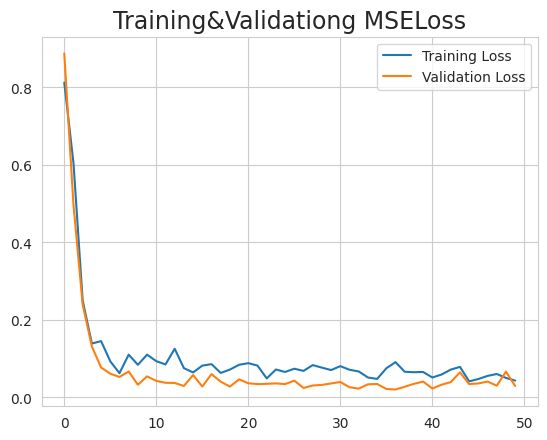

In [20]:
plot_results(history, config)

### 학습 결과 확인하기

In [21]:
class Tester:
    def __init__(self, model, cfg, device, test_dataset):
        self.cfg = cfg
        self.device = device
        self.model, self.criterion, self.optimizer = self.compile_(model)
        self.test_dataloader = self.create_test_dataloader(test_dataset)

    def create_test_dataloader(self, test_dataset):
        return  DataLoader(test_dataset, batch_size=1)


    def compile_(self, model):
        model = model.to(self.device)
        criterion = nn.__dict__[self.cfg.LOSS]().to(self.device)
        optimizer = torch.optim.__dict__[self.cfg.OPTIMIZER](model.parameters(), lr=1e-3)

        return model, criterion, optimizer

    def predict(self):
        predictions, losses = [], []
        with torch.no_grad():
            self.model.eval()
            for idx , seq_true in enumerate(self.test_dataloader):
                seq_true = seq_true.to(self.device)
                seq_pred = self.model(seq_true)
                loss = self.criterion(seq_pred, seq_true)
                predictions.append(seq_pred.cpu().numpy().flatten())
                losses.append(loss.item())

        return predictions, losses

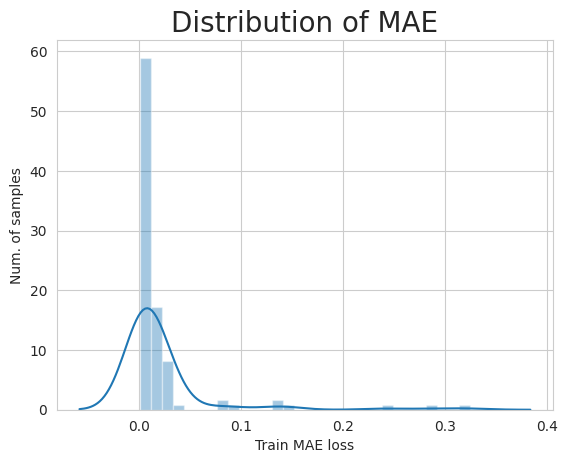

In [22]:
# train MAE 얻기 
_, losses = Tester(model, config,device, train_dataset).predict()

# MAE 분포 그리기 
plt.title('Distribution of MAE', fontsize=20)
sns.distplot(losses, bins=30, kde=True)
plt.xlabel("Train MAE loss")
plt.ylabel("Num. of samples")
plt.show()

### [TODO] 임계값 설정하기 

위에 MAE 분포를 확인하고 그에 맞는 임계값을 설정합니다. 

In [33]:
# 임계값 설정 하기
THRESHOLD = 0.2

## AutoEncoder 모델 평가하기

### 예측하기

In [34]:
# 모델 사용하여 예측
test_dataset = AutoencoderDataset(X_test)
predictions, pred_losses = Tester(model, config,device, test_dataset).predict()

###  [TODO] 임계값 넘는 이상치 탐지

임계치를 확인하고 임계치를 넘는 이상치를 감지합니다.
- test_mae_loss에서 임계치를 넘는 이상치를 찾습니다.

In [35]:
def detect_anomalies(testing,  pred_losses, threshold_value):
    #############################
    # 1. 임계치 넘는 이상치 탐지
    ############################
    # 이상치 갯수 구하기 
    test_mae_loss = np.array(pred_losses)
    print(f"[INFO] 임계치(threshold): {threshold_value:.4f}")
    anomalies = test_mae_loss > threshold_value
    print(f"[INFO] 임계치 넘는 이상치 개수: {np.sum(anomalies)}/{len(pred_losses)}")
    
    
    # MAE histogram 그리기
    plt.title('Distribution of MAE', fontsize=20)
    sns.distplot(pred_losses, bins=30, kde=True)
    plt.axvline(threshold_value,  color='red', linestyle='--', linewidth=1.5)
    plt.xlabel("test MAE loss")
    plt.ylabel("No of samples")
    plt.show()

    ##################################
    # 2. 타임스탬프 되돌리기
    ##################################
    # 주어진 데이터 i 가 이상치라면 (i - timesteps + 1) 에 해당하는 구간이 이상치 이기 떄문
    anomalous_indices = []

    for data_idx in range(TIME_STEPS - 1, len(test_value) - TIME_STEPS + 1):
        if np.any(
            anomalies[data_idx - TIME_STEPS + 1 : data_idx]
        ):  # 구간안에 모든 것이 True 면 ...
            anomalous_indices.append(data_idx)  # append 시키기

    ##################################
    # 3. DataFrame 만들기
    #################################
    df = testing.reset_index()
    df.columns = ["ds", "y"]
    df["anomaly"] = 0
    df["anomaly"].iloc[anomalous_indices] = 1
    df["yhat_lower"] = df["y"]
    df["yhat_upper"] = df["y"]
    return df
    

In [36]:
def plot_anomalies(pred):
    total_indices = list(range(len(pred)))
    total_values = pred["y"].values

    abnormal_indices = pred[pred["anomaly"] != 0].index.values
    abnormal_values = pred[pred["anomaly"] != 0]["y"].values

    abnormal_consecutive_list = []
    cur_abnormal_idx_subrange = []
    cur_abnormal_val_subrange = []
    for abnormal_idx, abnormal_val in zip(abnormal_indices, abnormal_values):
        if (
            len(cur_abnormal_idx_subrange) == 0
            or abnormal_idx - cur_abnormal_idx_subrange[-1] == 1
        ):
            cur_abnormal_idx_subrange.append(abnormal_idx)
            cur_abnormal_val_subrange.append(abnormal_val)
        else:
            abnormal_consecutive_list.append(
                (cur_abnormal_idx_subrange, cur_abnormal_val_subrange)
            )
            cur_abnormal_idx_subrange = [abnormal_idx]
            cur_abnormal_val_subrange = [abnormal_val]

    abnormal_consecutive_list.append(
        (cur_abnormal_idx_subrange, cur_abnormal_val_subrange)
    )

    # 그림 그리기
    plt.plot(total_indices, total_values, color="green")
    for abnormal_idx, abnormal_val in abnormal_consecutive_list:
        plt.plot(abnormal_idx, abnormal_val, color="r")

    plt.show()


[INFO] 임계치(threshold): 0.2000
[INFO] 임계치 넘는 이상치 개수: 0/48


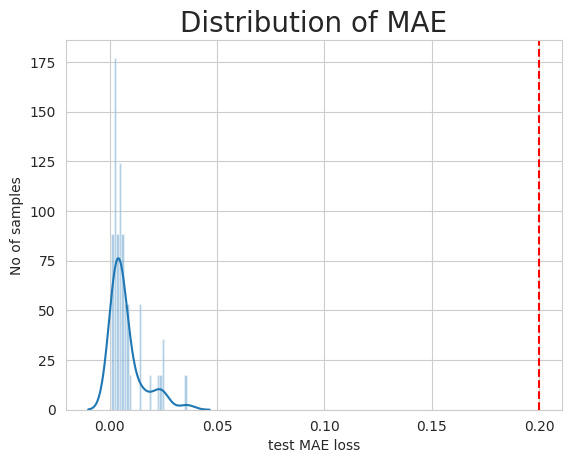

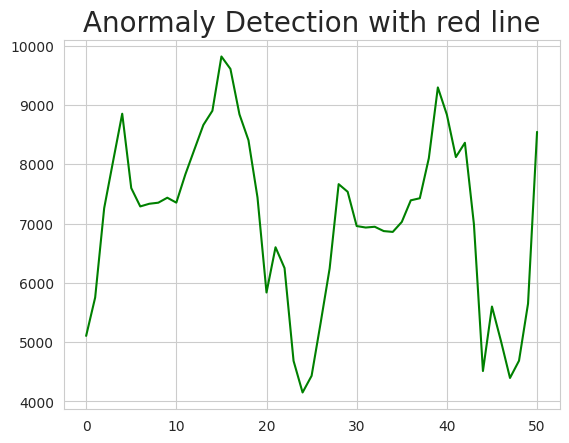

In [37]:
# 데이터 확인 
df= detect_anomalies(testing,  pred_losses, THRESHOLD)

# 그래프 확인
plt.title(f"Anormaly Detection with red line", fontsize=20)
plot_anomalies(df)

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>